## Preface



If need be&#x2026;



In [1]:
!pip install -r requirements.txt

## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:


| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|i,t,m|j|
| Consumption|i,t,m,u|j|
| Prices|j,u|t,m|
| HH Characteristics|i,t,m|k|
| FCT|j,u|n|
| RDI|n|k|

where `i` indexes households, `t` indexes periods, `m` indexes
markets, `j` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



## Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [7]:
InputFiles = {'Expenditures':('1YupX14TogoubSrlHtG9OgfBdKUhsss29L63mcNDNCUo','Food Expenditures'),
              'Prices':('1YupX14TogoubSrlHtG9OgfBdKUhsss29L63mcNDNCUo','Food Prices'),
              'HH Characteristics':('1YupX14TogoubSrlHtG9OgfBdKUhsss29L63mcNDNCUo','Household Characteristics'),
              'FCT':('1YupX14TogoubSrlHtG9OgfBdKUhsss29L63mcNDNCUo','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

In [6]:
#expenditures = pd.read_csv('Guatemala_Food_Expenditures.csv')
#prices = pd.read_csv('Guatemala_Food_Prices.csv')
#characteristics = pd.read_csv('Guatemala_Household_Characteristics.csv')
#FCT = pd.read_csv('Guatemala_FCT.csv')

In [ ]:
#inputfiles = {'Expenditures': expenditures, 
#              'Prices': prices, 
#              'HH Characteristics': characteristics, 
#              'FCT': FCT, 
#              'RDI': 

#### Amy's advice for setting indices: 
- separate Ligon's code by each time the spreadsheets are loaded in and deconstructed
- set indices there, manually, rather than running the entire cell below at once

In [8]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['i','t','m'])
x.columns.name = 'j'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

KeyError: "None of ['t'] are in the columns"

## Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `Regression` result.



In [4]:
import cfe

result = cfe.Regression(y=np.log(x.stack()),d=z)

result.get_beta().sort_values(ascending=False) # Check sanity...

j
Ice Cream          1.739132
Juice (Branded)    1.721491
Bananas            1.667667
Milk               1.578322
Candies            1.555973
                     ...   
Other Sauces       0.644436
Beans              0.584281
Salt               0.554703
Tortillas          0.434879
Maize              0.013067
Name: beta, Length: 76, dtype: float64

Make this persistent&#x2026;



In [5]:
result.to_pickle('./foo.pickle')

## Step 3: Infer quantities



Next, we divide predicted expenditures by prices to get
quantities (in kilograms) we can map into the  FCT.



In [9]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

# units will be the same as units for prices (kg) -- make sure you know which units it's in 

In [10]:
qhat

,,j,Beans,Beef,Biscuits,Bread,Cabbages,Cassava,Chapati,Cooking Oil,Dodo,Eggs,...,Rice,Salt,Sim Sim,Soda,Sorghum,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi
i,t,m,,,,,,,,,,,,,,,,,,,,,
1013000201,2019-20,Central,1.702971,1.395917,0.530918,1.651148,0.533037,2.515609,2.415013,1.382495,1.517382,1.944924,...,1.561524,0.147278,0.603838,2.148505,1.060379,3.619254,3.464824,0.028501,3.174184,0.814354
1013000202,2019-20,Central,1.265999,0.581064,0.083042,0.428114,0.233304,2.600384,0.617087,0.665150,0.714996,1.042583,...,0.602969,0.166953,0.174339,0.383314,0.244560,1.158620,2.170142,0.011084,1.138156,0.439112
1013000204,2019-20,Central,1.792757,1.607249,0.481932,2.238453,0.600673,2.570199,3.826322,1.755477,1.569926,2.133189,...,1.778145,0.145998,0.792475,3.171860,1.406449,4.200826,2.872355,0.032560,4.201856,1.352902
1021000108,2019-20,Central,1.268451,0.693594,0.079326,0.479210,0.266447,2.343834,0.790744,0.766102,0.899532,1.097729,...,0.689040,0.148551,0.226748,0.679008,0.340561,1.445334,2.006863,0.015018,1.412546,0.583261
1021000109,2019-20,Central,2.346152,1.286748,0.455133,1.360539,0.532204,2.891195,2.124188,1.755327,1.363931,1.963371,...,1.563954,0.233270,0.522759,1.520216,1.085793,3.253938,2.931285,0.029228,3.248301,0.856068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_62,2019-20,Western,2.334711,0.910326,0.832193,0.638636,0.463422,3.808239,1.254272,0.397938,1.174682,1.425087,...,0.851333,0.213949,0.168151,0.922857,2.347182,1.578224,3.815918,0.020986,2.238318,1.422289
_67,2019-20,Western,1.488978,0.685097,0.460617,0.452921,0.366751,3.034359,0.913834,0.259806,0.924030,0.899626,...,0.562999,0.133222,0.100633,0.785010,1.571407,0.870357,2.736681,0.016447,1.602019,0.817422
a98bebba177243668464e31f6d2bb92d,2019-20,Western,6.668536,2.126969,0.698402,1.872154,0.839788,12.739902,2.486842,0.820129,2.909474,1.861239,...,2.816558,0.427049,0.269705,1.542834,6.380768,3.604458,11.850964,0.046589,4.162557,1.940772


Note that `qhat` may give prices for different *units*.  If prices
differ **only** because of units (e.g., one deciliter costs one
tenth as much as a liter), then we can use these differences in prices
to convert between different units, even if the units (e.g., &ldquo;basket&rdquo;)
is otherwise unclear.  

If we have enough data on purchases in kilograms, just keep those
prices (otherwise choose some other useful unit).  We also assume
prices are the same for everyone, so just take median.



## Step 4: Map predicted quantities into nutrients



Before this will work, need columns of qhat to match columns of fct.



In [13]:
fct
# assumed not to change over time or past markets

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomatoes,180,9.0,10.0,150,100,39.0,3.0,5.94,0.19,0.37,420,0.0,0.80,127,2.0
Waragi,2630,0.0,0.0,0,0,0.0,0.0,0.00,0.00,0.00,0,0.0,0.00,0,0.0
Watermelon,300,6.1,4.0,30,70,75.5,2.4,1.78,0.21,0.33,280,0.0,0.45,81,1.0


In [11]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:] # map together by multiplying the quantities -- food times the nutrients 
# [use] -- making sure that the indices in the matrix are perfect. 

nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          54394.359147
Protein          1543.135088
Fiber             719.013180
Folate          11133.452311
Calcium         17461.844887
Carbohydrate     7168.395869
Iron              423.974692
Niacin            431.775192
Riboflavin         38.594788
Thiamin            45.800022
Vitamin A        9683.206362
Vitamin B-12       60.013724
Vitamin B-6        51.591940
Vitamin C        5136.327910
Zinc              238.093310
dtype: float64

7770.622735285715

In [18]:
# here, we've gotten nutrients for all households, for every period
# note: the Energy is much larger, because it's over a week. so can divide for days
print(54394.359147/7)

# still getting a larger number. 
# in the previous vector, you're getting the averages across all households
nutrients

7770.622735285715


,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
1013000201,2019-20,Central,57508.875692,1641.569810,647.945448,10845.866829,18706.015042,6769.000294,424.526376,446.586477,40.432417,49.156202,8412.515708,73.057514,53.710505,3845.857488,253.142953
1013000202,2019-20,Central,21856.819126,636.019660,236.454144,4347.530675,6551.964039,2140.218490,149.166565,159.957077,16.258995,17.463203,3846.428414,33.573791,20.624024,1294.756412,97.614302
1013000204,2019-20,Central,73708.268819,2047.306777,803.581268,12870.889807,23561.523301,8749.880554,529.894138,562.799358,48.381852,62.978283,9586.528188,83.447689,64.488546,4663.470863,311.683924
1021000108,2019-20,Central,26412.663515,755.752845,293.562321,5111.082182,7973.804870,2683.105447,182.012488,194.950799,18.919509,21.105137,4469.028372,38.090450,25.193226,1592.603774,118.266484
1021000109,2019-20,Central,59021.612509,1637.010826,639.907439,10757.331067,17194.439819,6356.840401,402.272845,440.468224,39.671584,49.346949,8160.689228,71.865776,52.304754,3517.361151,248.413905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_62,2019-20,Western,43556.695944,1333.364461,584.684145,8756.799860,11182.102066,6201.064760,340.367404,371.291877,32.510380,39.124521,6986.597552,51.162975,39.551095,3325.340413,191.180127
_67,2019-20,Western,28376.163875,901.907353,377.497620,5688.744935,7547.725406,4053.757904,228.619487,248.106840,21.297732,25.948147,4672.453639,35.757255,25.990620,2129.326491,130.464716
a98bebba177243668464e31f6d2bb92d,2019-20,Western,94879.542280,2935.819338,1508.886461,20311.775123,25170.284312,14987.220294,795.828840,874.430556,68.816041,88.630607,13646.515704,95.884718,90.464485,8931.312645,436.858738


## Household Nutritional Adequacy



In [19]:
# think about LIKE an RDI, but for households rather than individuals

Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For each household, we know the numbers of people in different age-sex categories.  We can match these up with data from an RDI (Recommended Dietary Intakes), then sum over different types.



In [21]:
z = z[rdi.columns.tolist()]

# takes the count of the individual, multiplies by the RDI column (single matrix multiplier)
hh_rdi = z@rdi.T 

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7
hh_rwi

n                                                  Energy  Protein   Fiber  \
i                                t       m                                   
00c9353d8ebe42faabf5919b81d7fae7 2018-19          93800.0   2177.0  1313.2   
                                 2019-20 Eastern  82600.0   1939.0  1156.4   
02dd448165ce46279ca601a02865d543 2018-19          14000.0    322.0   196.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19          54600.0   1113.0   764.4   
039a11571b874a88b7a6c200469fe4f3 2018-19          60200.0   1323.0   842.8   
...                                                   ...      ...     ...   
e248935b902247b4896b90baab465344 2018-19          46200.0   1085.0   646.8   
edfcce99d80241cd8a7b5f7f169dc0a0 2018-19          89600.0   1904.0  1254.4   
ef69f1cfdaf44c1e81a81bf21c2981f4 2018-19          44800.0    938.0   627.2   
                                 2019-20 Central  15400.0    392.0   215.6   
f7d06fb530c04b839b70c86e2278baf7 2018-19          86800.0   1932.0  1215.2   

n                                                  Folate  Calcium  \
i                                t       m                           
00c9353d8ebe42faabf5919b81d7fae7 2018-19          19250.0  65800.0   
                                 2019-20 Eastern  17150.0  56700.0   
02dd448165ce46279ca601a02865d543 2018-19           2800.0   7000.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19           9800.0  35000.0   
039a11571b874a88b7a6c200469fe4f3 2018-19          11200.0  39200.0   
...                                                   ...      ...   
e248935b902247b4896b90baab465344 2018-19           9100.0  30100.0   
edfcce99d80241cd8a7b5f7f169dc0a0 2018-19          17150.0  62300.0   
ef69f1cfdaf44c1e81a81bf21c2981f4 2018-19           8050.0  25900.0   
                                 2019-20 Central   2800.0   7000.0   
f7d06fb530c04b839b70c86e2278baf7 2018-19          16100.0  53200.0   

n                                                 Carbohydrate   Iron  \
i                                t       m                              
00c9353d8ebe42faabf5919b81d7fae7 2018-19                7280.0  658.0   
                                 2019-20 Eastern        6370.0  602.0   
02dd448165ce46279ca601a02865d543 2018-19                 910.0  126.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19                4550.0  392.0   
039a11571b874a88b7a6c200469fe4f3 2018-19                4550.0  364.0   
...                                                        ...    ...   
e248935b902247b4896b90baab465344 2018-19                3640.0  308.0   
edfcce99d80241cd8a7b5f7f169dc0a0 2018-19                7280.0  644.0   
ef69f1cfdaf44c1e81a81bf21c2981f4 2018-19                3640.0  301.0   
                                 2019-20 Central         910.0   56.0   
f7d06fb530c04b839b70c86e2278baf7 2018-19                6370.0  539.0   

n                                                 Magnesium  Niacin  \
i                                t       m                            
00c9353d8ebe42faabf5919b81d7fae7 2018-19            15890.0   700.0   
                                 2019-20 Eastern    14210.0   616.0   
02dd448165ce46279ca601a02865d543 2018-19             2170.0    98.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19             7910.0   378.0   
039a11571b874a88b7a6c200469fe4f3 2018-19             9450.0   434.0   
...                                                     ...     ...   
e248935b902247b4896b90baab465344 2018-19             7770.0   350.0   
edfcce99d80241cd8a7b5f7f169dc0a0 2018-19            13440.0   644.0   
ef69f1cfdaf44c1e81a81bf21c2981f4 2018-19             6580.0   308.0   
                                 2019-20 Central     2940.0   112.0   
f7d06fb530c04b839b70c86e2278baf7 2018-19            14000.0   616.0   

n                                                 Phosphorus  Potassium  \
i                                t       m                                
00c9353d8ebe42faabf5919b81d7fae7 2018-19          

Now, what proportion of `hh_rwi` do households consume?



In [23]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

# construct the ratio: nutritional input in calories, divide by the household recommended WEEKLY intake
nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

# so if the ratio is above 1, then it's being exceeded, and vice-versa
nutrient_ratio

# the outputted dataframe will give decimal-valued percentage ratios for each nutrient relative to the recommended value

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.615096,0.722736,0.627115,0.736333,0.355585,1.086926,0.736215,0.664773,0.815046,0.890096,0.345513,0.473890,0.880288,1.792793,0.626514
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,0.809864,1.089355,0.771282,1.011306,0.544512,1.191057,1.010272,0.920214,1.076578,1.241203,0.456820,0.838280,1.382487,2.355469,0.917791
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.568972,0.785274,0.542669,0.720346,0.338427,0.853769,0.733177,0.646003,0.770529,0.882977,0.328414,0.610290,0.955996,1.634968,0.616956
1013000201,2019-20,Central,5.134721,5.098043,4.132305,3.873524,2.226907,7.438462,7.580828,4.557005,5.250963,6.383922,1.716840,4.348662,5.115286,7.325443,4.520410
1013000202,2019-20,Central,0.743429,1.081666,0.574476,0.776345,0.292498,0.783963,0.761054,0.761700,1.009875,1.084671,0.366327,0.999220,1.091218,1.479722,0.774717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,0.621330,0.806379,0.651366,0.829186,0.353094,0.982076,0.809916,0.685773,0.821752,0.910595,0.353696,0.567944,1.064349,2.324992,0.626486
c33f6cb57d9849949e08a7350dabb829,2019-20,Central,2.627785,2.671846,2.061023,2.015982,1.114663,3.473021,3.770880,2.266925,2.782092,3.168427,1.002933,2.563054,2.670821,3.632937,2.381274
d10a687889de469687377204195f3db0,2019-20,Western,0.658082,0.839498,0.670625,0.776954,0.320558,1.367045,1.163394,0.776283,0.891884,1.036948,0.301277,0.841180,0.998184,1.215716,0.650501


Graph ratios of adequacy for particular nutrients



<Axes: >

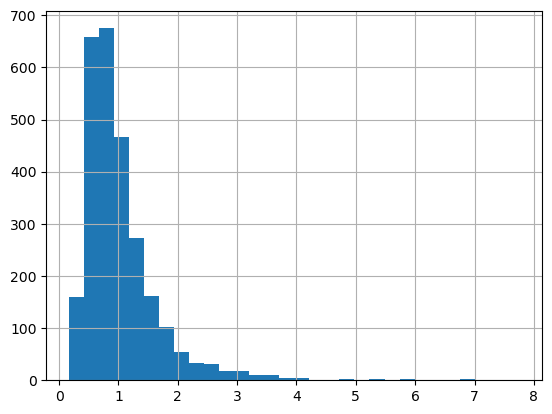

In [24]:
%matplotlib inline
nutrient_ratio['Energy'].hist(bins=30)

<Axes: >

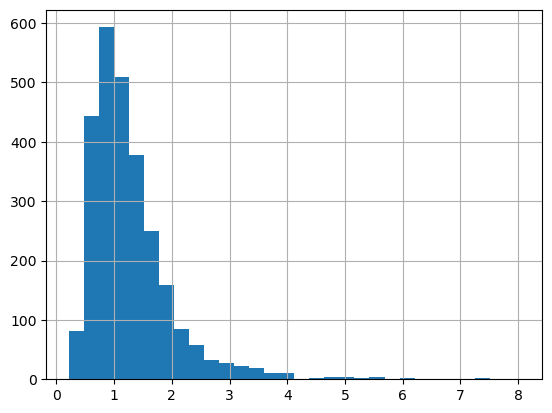

In [25]:
%matplotlib inline
nutrient_ratio['Protein'].hist(bins=30)

TypeError: 'value' must be an instance of str or bytes, not a tuple

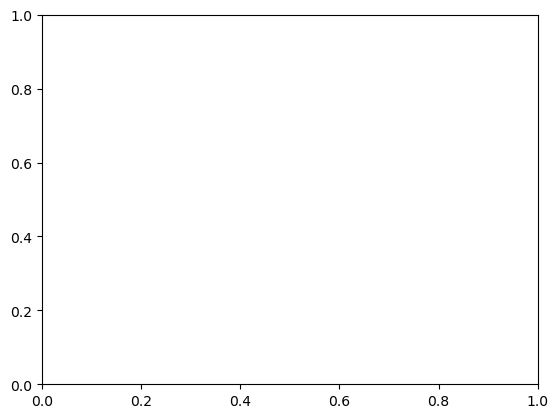

In [35]:
import matplotlib.pyplot as plt
plt.scatter(nutrient_ratio.index, nutrient_ratio['Energy'])